<img src="./logo_UTN.svg" align="right" width="150" /> 

#### Procesamiento Digital de Señales

# Tarea Semanal 6
#### Fernando Coda
  
## Estimación espectral a prueba: Ancho de banda del Electrocardiograma.

---
En esta tarea realizaremos el punto 4 del TP4

4) En el archivo **ECG_TP4.mat** encontrará un registro electrocardiográfico (ECG) registrado durante una prueba de esfuerzo, junto con una serie de variables descriptas a continuación. Diseñe y aplique los filtros digitales necesarios para mitigar las siguientes fuentes de contaminación:

- Ruido causado por el movimiento de los electrodos (Alta frecuencia)
- Ruido muscular (Alta frecuencia)
- Movimiento de la línea de base del ECG, inducido en parte por la respiración (Baja frecuencia)

### Archivo ECG_TP4.mat
(variables)

- **ecg_lead**: Registro de ECG muestreado a $fs=1$ KHz durante una prueba de esfuerzo
- **qrs_pattern1**: Complejo de ondas QRS normal
- **heartbeat_pattern1**: Latido normal
- **heartbeat_pattern2**: Latido de origen ventricular
- **qrs_detections**: vector con las localizaciones (en # de muestras) donde ocurren los latidos

a) Establezca una plantilla de diseño para los filtros digitales que necesitará para que la señal de ECG se asemeje a los latidos promedio en cuanto a suavidad de los trazos y nivel isoeléctrico nulo.

#### **Defina la plantilla del filtro**

fs0 = ?? # fin de la banda de detenida 0  
fc0 = ?? # comienzo de la banda de paso  
fc1 = ?? # fin de la banda de paso  
fs1 = ?? # comienzo de la banda de detenida 1  

In [1]:
import numpy  as np
from scipy import signal as sig
from scipy import io as sio
from matplotlib import pyplot as plt

def periodogram_welch(x_t, fs, window, nfft=None, L=None, D=None):
    N = len(x_t)
    if nfft is None:
        nfft = N
    if L is None:
        L = N//10
    if D is None:
        D = L//2 # 50% overlap

    f,Pxx = sig.welch(x_t,
                      fs=fs,
                      window=window,
                      nperseg=L,
                      noverlap=D,
                      nfft=nfft,
                      average='median',
                      axis=0 
                     )
    return f,Pxx

def graficar_espectro(f, X_f, fs, *args, **kwargs):
    bfrec = (f <= fs/2)
    X_f_dB = 20 * np.log10(np.abs(X_f))
    return plt.plot(f[bfrec], X_f_dB[bfrec], *args, **kwargs)

In [2]:
data = sio.loadmat('ECG_TP4.mat')

ecg_lead = data['ecg_lead']
qrs_detections = data['qrs_detections']
detections_len = len(qrs_detections)

qrs_detections = qrs_detections.reshape(qrs_detections.shape[0],)
ecg_lead = ecg_lead.reshape(ecg_lead.shape[0],)

fs = 1000
Ts = 1/fs

Veamos en primer lugar las características de un ECG en reposo, sin la presencia de latidos ventriculares.

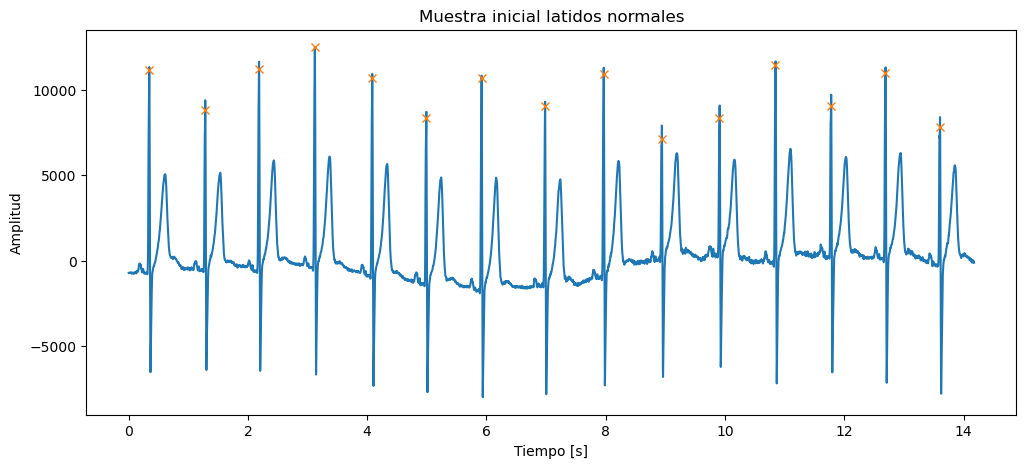

In [3]:
muestra_inicial = ecg_lead[9837:24015]

Ni = len(muestra_inicial)
ti = np.arange(start = 0, stop = Ni*Ts, step = Ts)

detections_muestra_inicial = qrs_detections[
    np.logical_and(qrs_detections>9837, qrs_detections<24015)] - 9837

detections_inicial_len = len(detections_muestra_inicial)

plt.figure(figsize=(12,5))
plt.plot(ti, muestra_inicial)
plt.plot(ti[detections_muestra_inicial], muestra_inicial[detections_muestra_inicial], 'x')

plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.title('Muestra inicial latidos normales')
plt.show()

En este primer caso se pueden ver latidos regulares casi sin distorsiones ni fuertes variaciones de continua en la señal.  

Veamos ahora el espectro de esta señal

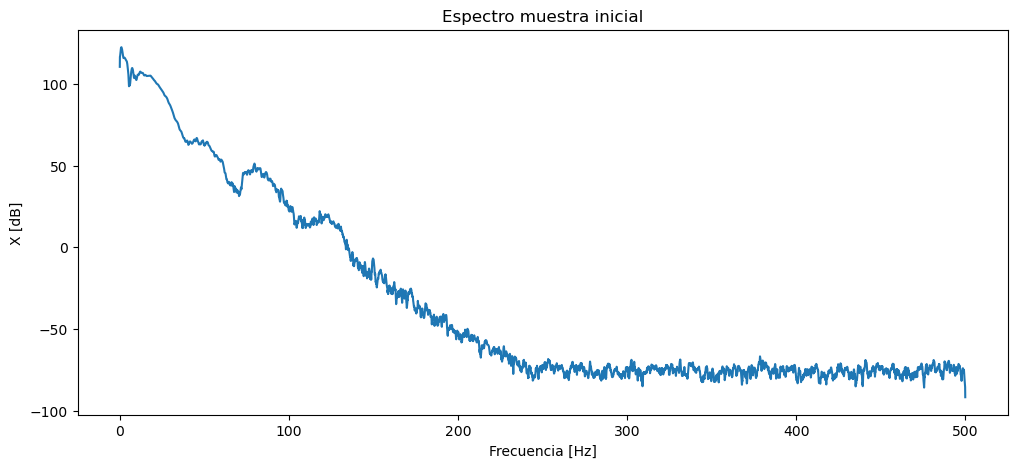

In [4]:
window='blackman'

ff_i, spec_inicial = periodogram_welch(muestra_inicial, fs, window)

plt.figure(figsize=(12,5))
graficar_espectro(ff_i, spec_inicial, fs, label='espectro base')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('X [dB]')
plt.title('Espectro muestra inicial');

Aún evaluando por Welch, tenemos una resolución deficiente en baja frecuencia. Esto lo solucionaremos más adelante agregando zero padding.  

El otro problema presente es que este espectro se ve muy ruidoso. Esto lo podemos mejorar tomando medias muestrales, para lo cual debemos individualizar cada latido y considerarlo como una muestra periódica. A cada una de estas señales le quitaremos su valor medio para eliminar la continua.

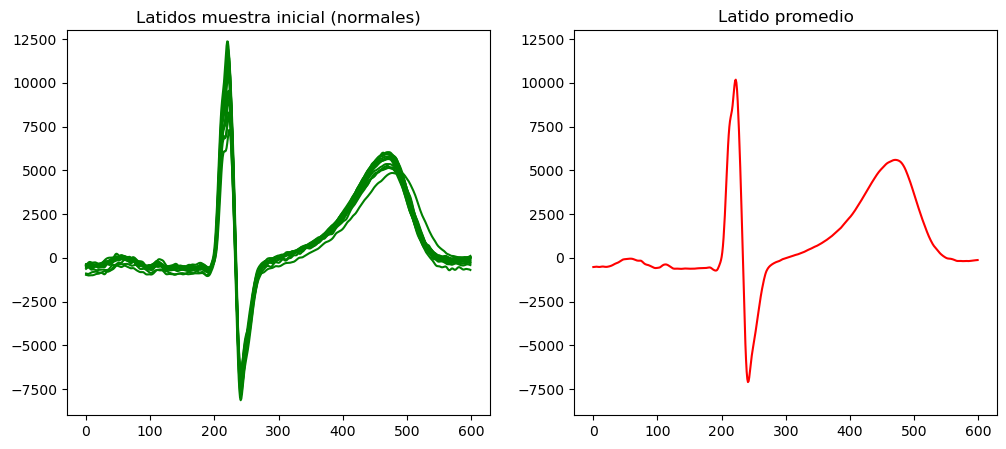

In [5]:
wleft = 220; wright = 380; w = wleft+wright
nmuestras = np.zeros((wleft+wright, detections_inicial_len))

for i in range(detections_inicial_len):
    x = detections_muestra_inicial[i]
    nmuestras[:,i] = muestra_inicial[x-wleft:x+wright].reshape(w,)
    nmuestras[:,i] -= np.median(nmuestras[:,i])

fig = plt.figure(figsize=(12,5))
ax = fig.subplots(1,2)
ax[0].plot(nmuestras, 'g')
ax[0].set_title('Latidos muestra inicial (normales)')
ax[0].set_ylim([-9000,13000])
ax[1].plot(np.mean(nmuestras,axis=1), 'r')
ax[1].set_title('Latido promedio')
ax[1].set_ylim([-9000,13000]);

A continuación, podemos calcular el ancho de banda de estas muestras como aquel que incluye el 90% del área en su espectro.

In [6]:
ff_mi, spec_muestras_inicial = periodogram_welch(nmuestras, fs, window)
spec_mean = np.mean(spec_muestras_inicial, axis=1)

total = np.sum(np.abs(spec_mean))
threshold = 0.98 * total
val = 0

for y in reversed(range(int(np.max(spec_mean)))):
    if spec_mean[(spec_mean > y)].sum() >= threshold:
        val = y
        break

BW = ff_mi[(spec_mean>val)]
fci = BW.min()
fcs = BW.max()

print("fci muestra inicial = " + str(fci))
print("fcs muestra inicial = " + str(fcs))
print("BW muestra inicial  = " + str(fcs-fci))

fci muestra inicial = 0.0
fcs muestra inicial = 38.333333333333336
BW muestra inicial  = 38.333333333333336


Veamos cómo quedó el espectro al promediar de esta manera

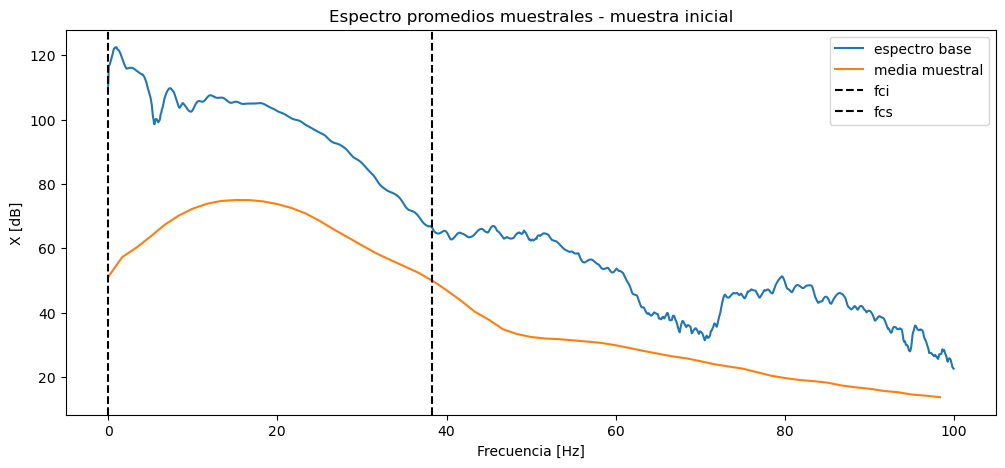

In [7]:
plt.figure(figsize=(12,5))
bfrec1 = ff_i<100
graficar_espectro(ff_i[bfrec1], spec_inicial[bfrec1], fs, label='espectro base')
bfrec2 = ff_mi<100
graficar_espectro(ff_mi[bfrec2], spec_mean[bfrec2], fs, label='media muestral')
plt.axvline(fci, linestyle='--', color='black', label='fci')
plt.axvline(fcs, linestyle='--', color='black', label='fcs');

plt.xlabel('Frecuencia [Hz]')
plt.ylabel('X [dB]')
plt.title('Espectro promedios muestrales - muestra inicial')
plt.legend();

Hasta aquí todo bien, pero ahora veamos lo que sucede en un ECG más completo con una prueba de esfuerzo

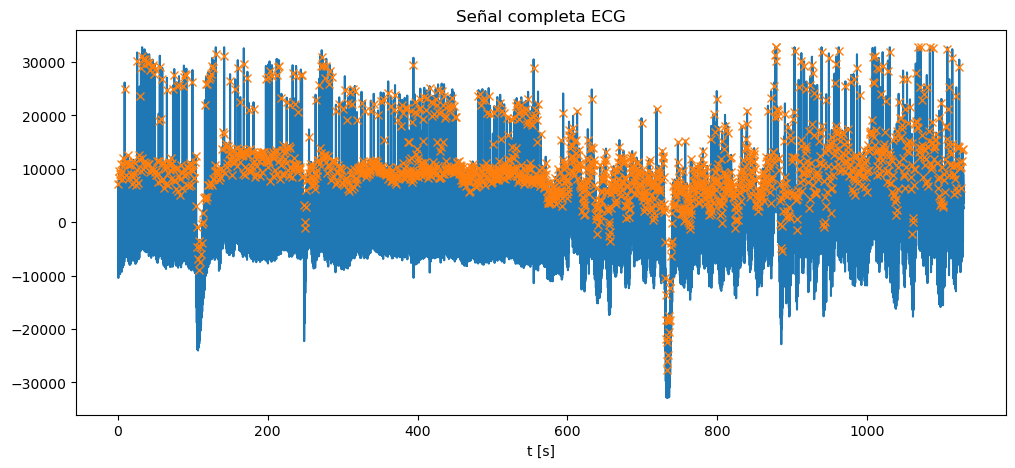

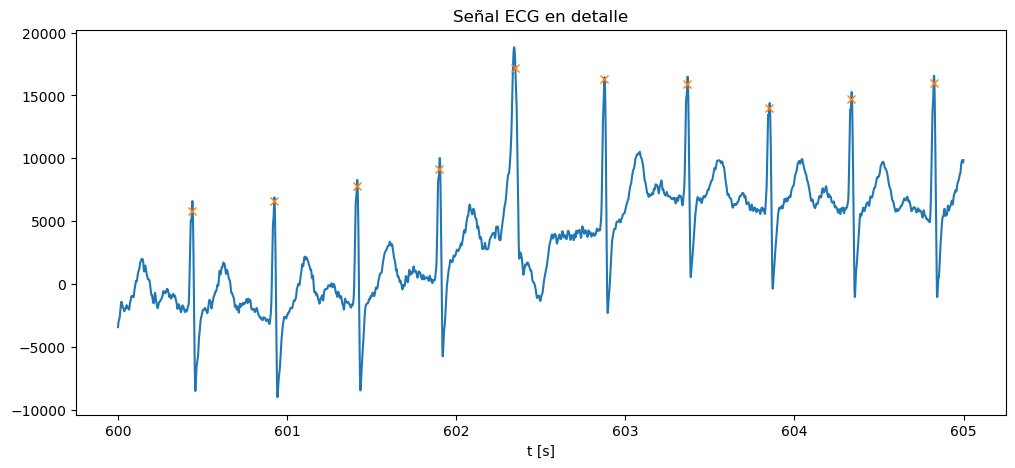

In [8]:
N = len(ecg_lead)
t = np.arange(start = 0, stop = N*Ts, step = Ts)
td = t[qrs_detections] # vector tiempo de detecciones

plt.figure(figsize=(12,5))
plt.plot(t,ecg_lead)
plt.plot(td, ecg_lead[qrs_detections].reshape((detections_len,1)), 'x')

plt.title('Señal completa ECG')
plt.xlabel('t [s]');

t1=600; t2=605
bt = np.logical_and(t>t1, t<t2)
btd = np.logical_and(td>t1, td<t2)

plt.figure(figsize=(12,5))
plt.plot(t[bt], ecg_lead[bt])
plt.plot(td[btd], ecg_lead[qrs_detections][btd], 'x')

plt.title('Señal ECG en detalle')
plt.xlabel('t [s]');

Se puede ver que hay variaciones muy amplias en el eje Y.

Por momentos las muestras se desplazan abruptamente como al rededor del segundo 100 o del 750. Esto se puede solucionar filtrando la señal como haremos más adelante.

Las cruces naranjas marcan las detecciones. Las detecciones con picos más altos son latidos ventriculares, los cuales difieren ampliamente del latido normal. A continuación vemos la diferencia entre cada uno.

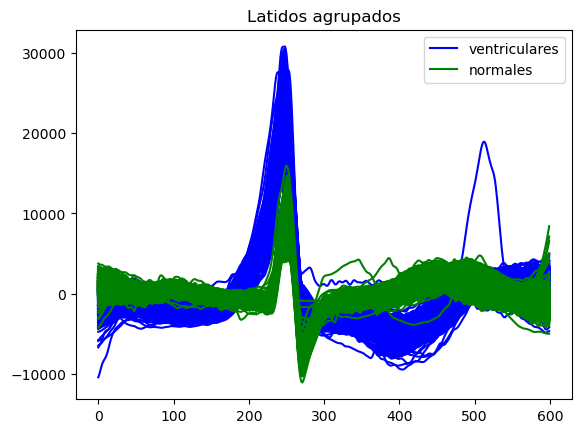

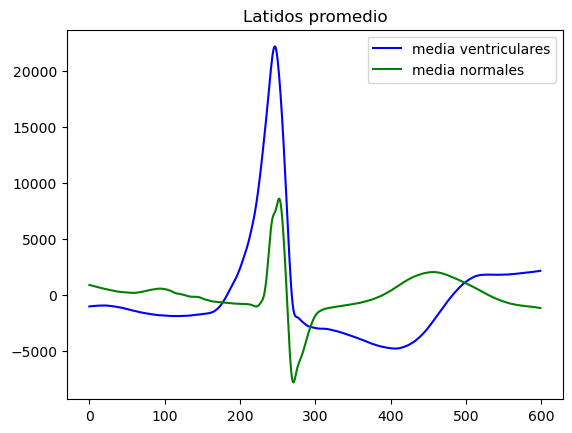

In [9]:
wleft = 250; wright = 350; w = wleft+wright
nmuestras = np.zeros((w, detections_len))

for i in range(detections_len):
    x = qrs_detections[i]
    nmuestras[:,i] = ecg_lead[x-wleft : x+wright]
    sig.detrend(nmuestras[:,i], axis=0, overwrite_data=True)

### separación visual, no muy reliable pero funciona
ventriculares = (nmuestras[218,:] > 1610)
nmuestras_ventric = nmuestras[:,ventriculares]
nmuestras_normales = nmuestras[:,~ventriculares]

ax = plt.gca()
*line, = ax.plot(nmuestras_ventric, 'b')
line[0].set_label('ventriculares')
*line, = ax.plot(nmuestras_normales, 'g')
line[0].set_label('normales')
plt.title('Latidos agrupados')
plt.legend();

plt.figure()
plt.plot(np.mean(nmuestras_ventric,  axis=1), 'b', label='media ventriculares')
plt.plot(np.mean(nmuestras_normales, axis=1), 'g', label='media normales')
plt.title('Latidos promedio')
plt.legend();

In [10]:
# Espectro 
f, spec = periodogram_welch(ecg_lead, fs, window)
f_m, spec_ecg = periodogram_welch(nmuestras, fs, window, nfft=2*w)
spec_mean = np.mean(spec_ecg, axis=1)

In [11]:
# Cálculo de BW
total = np.sum(np.abs(spec_mean))
threshold = 0.90 * total
val = 0

for y in reversed(range(int(np.max(spec_mean)))):
    if spec_mean[(spec_mean > y)].sum() >= threshold:
        val = y
        break

BW = f_m[(spec_mean>val)]
fci = BW.min()
fcs = BW.max()
print("fci = " + str(fci))
print("fcs = " + str(fcs))
print("BW  = " + str(fcs-fci))

fci = 0.0
fcs = 41.66666666666667
BW  = 41.66666666666667


Planteamos un filtro lineal de tipo IIR

In [12]:
# filter design
ripple = 0 / 2 # dB
atenuacion = 40 / 2 # dB

ws1 = fci+0.1 #Hz
wp1 = fci+1   #Hz
wp2 = fcs-5   #Hz
ws2 = fcs+5   #Hz

nyq_frec = fs/2

frecs = np.array([0.0, ws1, wp1, wp2, ws2, nyq_frec]) / nyq_frec
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])
gains = 10**(gains/20)

bp_sos_butter = sig.iirdesign(wp=np.array([wp1, wp2]) / nyq_frec, ws=np.array([ws1, ws2]) / nyq_frec, 
                              gpass=0.5, gstop=40., analog=False, ftype='butter', output='sos')

# Filtrado de señal
ecg_filt = sig.sosfiltfilt(bp_sos_butter, ecg_lead)

# Espectro filtrado
_, spec_filt = periodogram_welch(ecg_filt, fs, window)


# Individualizamos muestras y promediamos
nmuestras_filt = np.zeros((w, detections_len))

for i in range(detections_len):
    x = qrs_detections[i]
    nmuestras_filt[:,i] = ecg_filt[x-wleft : x+wright]
    sig.detrend(nmuestras_filt[:,i], axis=0, overwrite_data=True)
    
nmuestras_mean = np.mean(nmuestras,axis=1)

# Espectro filtrado, media por muestras
_, spec_ecg_filt = periodogram_welch(nmuestras_filt, fs, window, nfft=2*w)
spec_mean_filt = np.mean(spec_ecg_filt, axis=1)

Veamos cómo quedó la señal filtrada

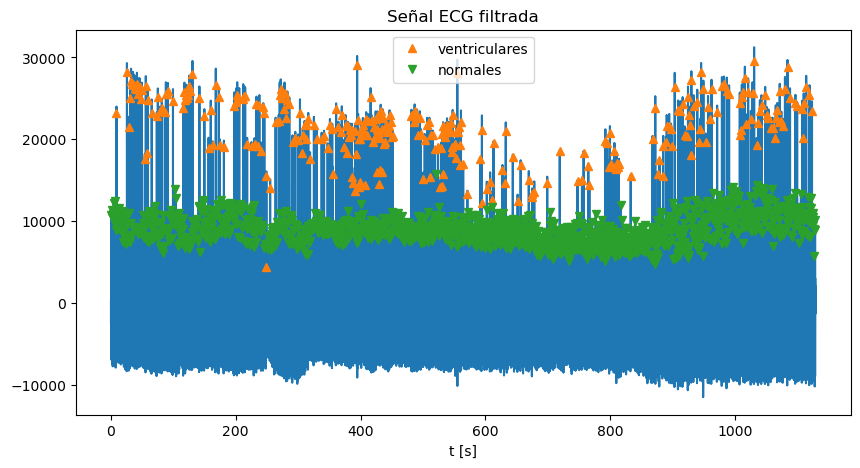

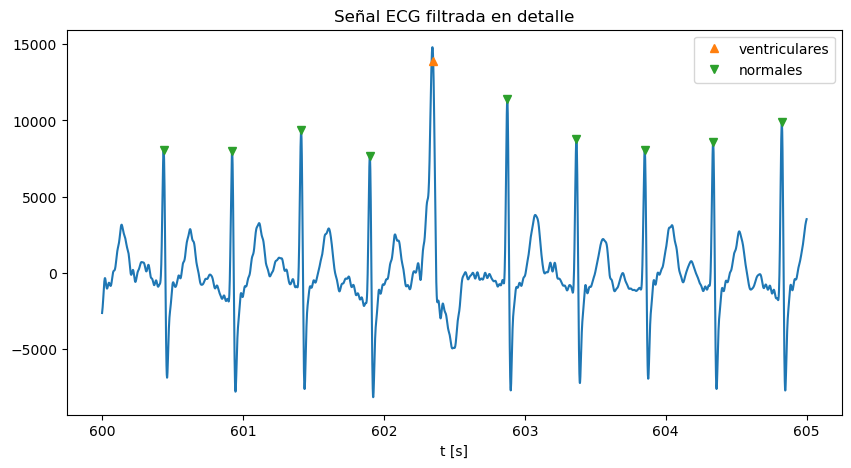

In [13]:
plt.figure(figsize=(10,5))
plt.plot(t, ecg_filt)
plt.plot(td[ventriculares], ecg_filt[qrs_detections][ventriculares], 
         '^', label='ventriculares')
plt.plot(td[~ventriculares], ecg_filt[qrs_detections][~ventriculares], 
         'v', label='normales')
plt.title('Señal ECG filtrada')
plt.xlabel('t [s]')
plt.legend();

plt.figure(figsize=(10,5))
plt.plot(t[bt], ecg_filt[bt])
plt.plot(td[btd &  ventriculares], ecg_filt[qrs_detections][btd &  ventriculares], '^', label='ventriculares')
plt.plot(td[btd & ~ventriculares], ecg_filt[qrs_detections][btd & ~ventriculares], 'v', label='normales')
plt.title('Señal ECG filtrada, en detalle')
plt.xlabel('t [s]')
plt.legend();

Se puede observar que desaparecen la mayoría de variaciones sobre 

Por último vemos el espectro

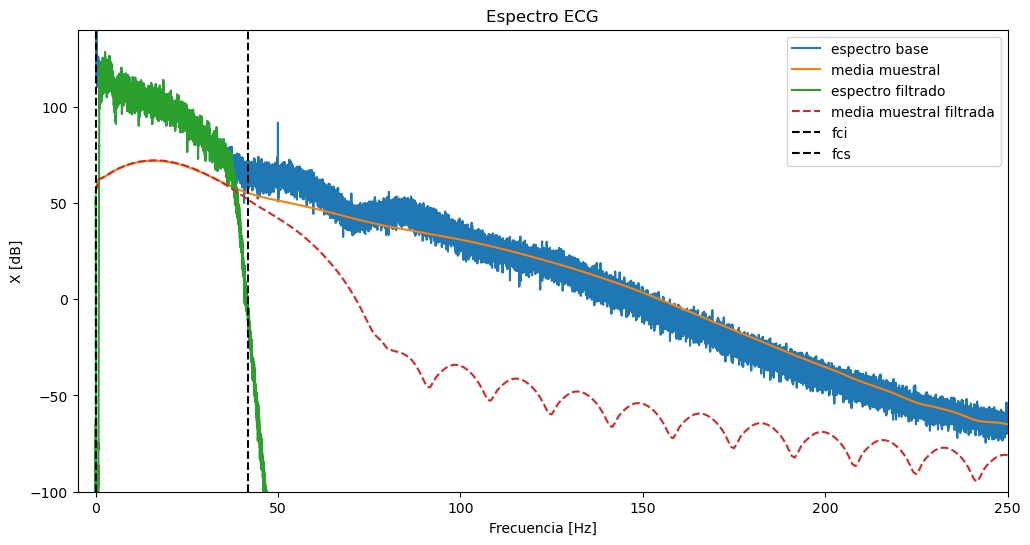

In [14]:
plt.figure(figsize=(12,6))
graficar_espectro(f, spec, fs, label='espectro base')
graficar_espectro(f_m, spec_mean, fs, label='media muestral')
graficar_espectro(f, spec_filt, fs, label='espectro filtrado')
graficar_espectro(f_m, spec_mean_filt, fs, '--', label='media muestral filtrada')
plt.axvline(fci, linestyle='--', color='black', label='fci')
plt.axvline(fcs, linestyle='--', color='black', label='fcs')
plt.legend()
plt.xlabel('Frecuencia [Hz]'), plt.ylabel('X [dB]')
plt.xlim([-5, 250]), plt.ylim([-100, 140])
plt.title('Espectro ECG');

Como podemos ver en la línea rayada roja, se eliminó el ruido de alta frecuencia, superior a los 40Hz (ruido muscular y de movimiento de los electrodos), se eliminó también el ruido de muy baja frecuencia, menor a 1Hz (respiración entre otros factores), y por medio del promediado muestral se logró un espectro mucho más limpio, eliminando también los ruidos aleatorios que varían muestra a muestra.